数据集地址：https://tianchi.aliyun.com/dataset/dataDetail?dataId=56  
从一份淘宝平台的广告点击数据，分析数据中的规律，给运营团队提出建议。  
指标维度梳理：  
**广告点击人数 = 广告展示数 x 点击率**  
在广告展示数一定的条件下，对**点击率**进行分析。
对点击率进行维度梳理：  
1.广告角度  
- 从商品价格维度分析对点击率的影响
- 从商品类别维度分析对点击率的影响  
2.用户角度
- 结合聚类模型分析不同用户群体与点击率的联系


### 数据清洗

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

ad_feature = pd.read_csv('ad_feature.csv')
raw_sample = pd.read_csv('raw_sample.csv')
user_profile = pd.read_csv('user_profile.csv')

#抽取所需要的列进行分析，从raw_sample数据集中抽取：用户ID、广告ID、是否点击 
#从ad_feature数据集中抽取：广告ID、类目ID、广告商品价格 
#从user_profile数据集中抽取：用户ID、年龄层、性别、购物层次
raw_sample = raw_sample[['user','adgroup_id','clk']]
ad_feature = ad_feature[['adgroup_id','cate_id','price']]
user_profile = user_profile[['userid','age_level','final_gender_code','shopping_level']]

#重命名列名
raw_sample.rename(columns={'user': 'userid'}, inplace=True)

#整合数据
df = pd.merge(raw_sample,ad_feature,left_on='adgroup_id',right_on='adgroup_id',how='left')
df = pd.merge(df,user_profile,left_on='userid',right_on='userid',how='left')

df.head()

,userid,adgroup_id,clk,cate_id,price,age_level,final_gender_code,shopping_level
0,581738,1,0,9025,17.0,2.0,1.0,3.0
1,449818,3,0,5998,1.0,NaN,NaN,NaN
2,914836,4,0,7958,85.0,5.0,2.0,3.0
3,914836,5,0,7958,60.0,5.0,2.0,3.0
4,399907,8,0,1626,63.0,5.0,2.0,3.0


In [2]:
df.shape

(26557961, 8)

In [3]:
#缺失值
df.isnull().sum()

userid                     0
adgroup_id                 0
clk                        0
cate_id                    0
price                      0
age_level            1528526
final_gender_code    1528526
shopping_level       1528526
dtype: int64

In [17]:
#缺失值处理
df.dropna(axis=0, how='any',inplace=True)

In [4]:
df.shape

(26557961, 8)

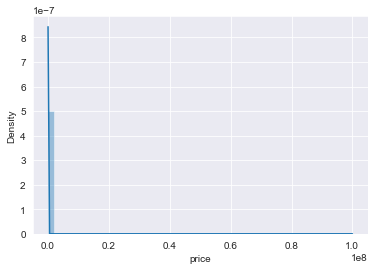

In [19]:
#离群值处理
#查看广告商品价格区间
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

df_price = df['price']
sns.distplot(df_price);

In [5]:
df['price'].max()

99999999.0

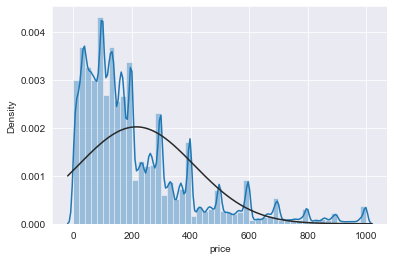

In [21]:
#Price column outlier
from scipy.stats import norm#for some statistics

df_price_limit = df[df['price']<1000]['price']
sns.distplot(df_price_limit, fit=norm);

结合两图发现,商品价格最大为99999999.0元，且商品价格呈偏正态分布，多数商品价格区100元左右，选取贴合正常标价的1000以内的广告商品价格进行分析。

In [6]:
#选取商品价格在1000元以内的行
df.drop(df[df.price > 1000].index, inplace=True)

In [7]:
#对商品价格进行区间划分
df['price_level'] = pd.cut(df['price'],bins=[0,100,200,300,400,500,600,700,800,900,1000]
       ,labels=['0-100','100-200','200-300','300-400','400-500','500-600'
                ,'600-700','700-800','800-900','900-1000'])

### 1.1 从商品价格维度分析对点击率的影响

In [24]:
import pyecharts.options as opts
from pyecharts.charts import Line

#不同价格层次的点击率
data_clk = (df.groupby('price_level')['clk'].mean()*100).round(2)

x1 = data_clk.index.tolist()
y1 = data_clk.values
c = (
    Line(init_opts=opts.InitOpts(width="1600px", height="800px"))
    .add_xaxis(x1)
    .add_yaxis("点击率", y1,
               markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average")]))
    .set_global_opts(title_opts=opts.TitleOpts(title="商品价格对点击率的影响"),
                    yaxis_opts=opts.AxisOpts(
                        min_=4.5,
                        max_=6,
                        interval=0.5,
                    ))
).render('表1 商品价格对点击率的影响.html')#保存到html文件中

从表1中发现，0-1000元价格区间商品的点击率在4.9%左右，其中0-100元以内商品的广告点击率最高，为5.5%；假设0-100元价格区间内的广告商品点击对象主要是浅层用户，进行检验。

In [25]:
from pyecharts.charts import Pie

#不同购物层次的用户在0-100元区间点击广告的数量
data_shopping = df[df['price_level'] == '0-100']['shopping_level'].value_counts()
data_shopping.index = ['深层','中层','浅层']

c = (
    Pie(init_opts=opts.InitOpts(width="1600px", height="800px"))
    .add("", [list(z) for z in zip(data_shopping.index,data_shopping.values.tolist())])
    .set_global_opts(title_opts=opts.TitleOpts(title="0-100元内不同层次用户点击广告商品的数量分布"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
).render('表2 0-100元内不同层次用户点击广告商品的数量分布.html')

从表2中发现，深层用户比例更高，浅层比例用户少，推翻原假设。

### 1.2 从商品类别维度分析对点击率的影响

由于商品类别数量多，本次选取数量最多的前10个类别进行分析

In [26]:
from pyecharts.charts import Bar

#不同类目商品的数量
cate_show = df['cate_id'].value_counts()

#不同类目商品的点击量
cate_clk = df.groupby('cate_id')['clk'].sum()

#选取数量最多的前10个类别
d = pd.DataFrame({'cate_show':cate_show,'cate_clk':cate_clk})
d = d.sort_values(by='cate_show',ascending=False)[:10]

#计算点击率
d['clk_rate'] = (d['cate_clk'] / d['cate_show']*100).round(2)
y2 = d['clk_rate'].values.tolist()

#图表横坐标
x2 = d.index.tolist()
x3 = [ str(i) for i in x2 ]

line = (
    Line()
    .add_xaxis(xaxis_data=x3)
    .add_yaxis(
        series_name="点击率",
        yaxis_index=1,
        y_axis=y2,
        label_opts=opts.LabelOpts(is_show=False),
    )
)

bar = (
    Bar(init_opts=opts.InitOpts(width="1600px", height="800px"))
    .add_xaxis(xaxis_data=x3)
    .add_yaxis("展示数",d['cate_show'].tolist(),
        label_opts=opts.LabelOpts(is_show=False),
    )
    .add_yaxis("点击数",d['cate_clk'].tolist(),
        label_opts=opts.LabelOpts(is_show=False),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="点击率",
            type_="value",
            min_=0,
            max_=7,
            interval=1,
            #axislabel_opts=opts.LabelOpts(formatter="{value} °C"),
        )
    )
    .set_global_opts(
        tooltip_opts=opts.TooltipOpts(
            is_show=True, trigger="axis", axis_pointer_type="cross"
        ),
        xaxis_opts=opts.AxisOpts(
            type_="category",
            axispointer_opts=opts.AxisPointerOpts(is_show=True, type_="shadow"),
        ),
        yaxis_opts=opts.AxisOpts(
            name="数量",
            type_="value",
            min_=0,
            max_=3000000,
            interval=500000,
            #axislabel_opts=opts.LabelOpts(formatter="{value} ml"),
            axistick_opts=opts.AxisTickOpts(is_show=True),
            splitline_opts=opts.SplitLineOpts(is_show=True),
        ),
    )
).overlap(line).render("表3 不同类别广告的展示数、点击数与点击率.html")

由表3看出商品类别6261的展示数、点击数、点击率均为最高，而4520类别的商品虽然展示数较高，但点击率确是最低的。  
分析4520广告效果差的原因：  
假设是由于商品价格引起的

In [27]:
price_clk = round(df[(df.cate_id == 4520) & (df.clk == 1)]['price'].mean(),2)
price_noclk = round(df[(df.cate_id == 4520) & (df.clk == 0)]['price'].mean(),2)
print('没被点击的4520广告商品的平均价格{}'.format(price_clk))
print('点击的4520广告商品的平均价格{}'.format(price_noclk))

没被点击的4520广告商品的平均价格125.92
点击的4520广告商品的平均价格133.8


两者的平均价格都在100-200区间内，相差不大，说明价格不是影响4520点击率的因素，原假设不成立。  
假设是由于性别引起的

In [28]:
male = df[(df.cate_id == 4520) & (df.final_gender_code == 1.0)].shape[0]
female = df[(df.cate_id == 4520) & (df.final_gender_code == 2.0)].shape[0]
print('类别4520的男性展示数为{}'.format(male))
print('类别4520的女性展示数为{}'.format(female))
male_clk = round(df[(df.cate_id == 4520) & (df.final_gender_code == 1.0)]['clk'].mean(),3)
female_clk = round(df[(df.cate_id == 4520) & (df.final_gender_code == 2.0)]['clk'].mean(),3)
print('男性点击率为{}'.format(male_clk))
print('女性点击率为{}'.format(female_clk))

类别4520的男性展示数为169357
类别4520的女性展示数为858542
男性点击率为0.046
女性点击率为0.047


类别4520的广告主要推荐给了女性用户，男性女性的点击率相当。对女性用户展示量更高但点击数却不高是造成类别4520点击率低的原因。

### 2.1结合聚类模型分析不同用户群体与点击率的联系

### Feature Engineering

In [29]:
#删去相同userid的行
df = df.drop_duplicates(subset=['userid'], keep='first')
df1 = df.copy()

#为clk创建分类变量
df1['clkCat'] = ''
df1['clkCat'].loc[(df1['clk'] == 0)] = 'no'
df1['clkCat'].loc[(df1['clk'] == 1)] = 'yes'

#为age_level创建分类变量
df1['age_levelCat'] = ''
df1['age_levelCat'].loc[(df1['age_level'] == 0)] = '0'
df1['age_levelCat'].loc[(df1['age_level'] == 1)] = '1'
df1['age_levelCat'].loc[(df1['age_level'] == 2)] = '2'
df1['age_levelCat'].loc[(df1['age_level'] == 3)] = '3'
df1['age_levelCat'].loc[(df1['age_level'] == 4)] = '4'
df1['age_levelCat'].loc[(df1['age_level'] == 5)] = '5'
df1['age_levelCat'].loc[(df1['age_level'] == 6)] = '6'

#为final_gender_code创建分类变量
df1['final_gender_codeCat'] = ''
df1['final_gender_codeCat'].loc[(df1['final_gender_code'] == 2)] = 'female'
df1['final_gender_codeCat'].loc[(df1['final_gender_code'] == 1)] = 'male'

#为shopping_level创建分类变量
df1['shopping_levelCat'] = ''
df1['shopping_levelCat'].loc[(df1['shopping_level'] == 1)] = '1'
df1['shopping_levelCat'].loc[(df1['shopping_level'] == 2)] = '2'
df1['shopping_levelCat'].loc[(df1['shopping_level'] == 3)] = '3'

#去除无用的列
df1.drop(['userid','adgroup_id','clk','cate_id','age_level','final_gender_code','shopping_level','price_level'],axis=1,inplace=True)

#对变量拆分为数值变量和分类变量
categorical_data = df1.select_dtypes(include=['object'])
numeric_data = df1.select_dtypes(exclude=['object'])

#记录变量名称
categorical_columns = list(categorical_data.columns)
numeric_columns = list(numeric_data.columns)
    
print('分类变量:\n',categorical_columns)
print('\n数值变量:\n',numeric_columns)

分类变量:
 ['clkCat', 'age_levelCat', 'final_gender_codeCat', 'shopping_levelCat']

数值变量:
 ['price']


### Pipeline Construction

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer

def definePipeline(categorical_columns, numeric_columns):
    
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
    
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])
    
    data_transformations = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_columns),
                                                             ('cat', categorical_transformer, categorical_columns)])
    
    datapipeline = Pipeline(steps=[('data_transformations', data_transformations)])
        
    return datapipeline
    
datapipeline = definePipeline(categorical_columns, numeric_columns)   
df1 = df1.iloc[:400000,:]
transformed = datapipeline.fit(df1)
data_sacle = transformed.transform(df1)

### K-Means聚类模型

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Defining a function to find the optimal number of K-Means' n_clusters parameter:
def findOptimalNClustersKMeans(data_sacle):
    
    # Number of clusters to search for and silhouette_scores list
    range_n_clusters = [2,3,4,5]
    silhouette_scores = []
    silhouette_int = -1 #Initialized value

    # Testing n_clusters options
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=7)
        cluster_labels = kmeans.fit_predict(data_sacle)
        
        # Evaluating clusters created by KMeans
        silhouette_avg = silhouette_score(data_sacle, cluster_labels)
        print("K-Means: for n_clusters =", n_clusters, ", the average silhouette_score is", silhouette_avg)
        
        # Appending iteration's avg silhouette score to scores list
        silhouette_scores.append(silhouette_avg)
        
        #If the average number of contours is higher
        if silhouette_avg > silhouette_int:
            silhouette_int = silhouette_avg
            cluster_labels_k = cluster_labels#Save cluster labels
        
    return range_n_clusters, silhouette_scores,cluster_labels_k

range_n_clusters, silhouette_scores,cluster_labels_k = findOptimalNClustersKMeans(data_sacle)

K-Means: for n_clusters = 2 , the average silhouette_score is 0.3072594219148097
K-Means: for n_clusters = 3 , the average silhouette_score is 0.2777361914079502
K-Means: for n_clusters = 4 , the average silhouette_score is 0.3437892042917374
K-Means: for n_clusters = 5 , the average silhouette_score is 0.3711283576497147


In [36]:
import plotly.graph_objs as go
import plotly

elbow_kmeans = go.Scatter(x=range_n_clusters,
                          y=silhouette_scores,
                          mode='lines',
                          name='kmeans elbow line',
                          marker_color='orange')

layout_elbow_kmeans = go.Layout(title='Number of clusters x Average Silhouette Score, K-Means Algorithm',
                          xaxis=dict(title='n_clusters'), yaxis=dict(title='Average Silhouette Score'))

elbow_kmeans = go.Figure(data=elbow_kmeans, layout=layout_elbow_kmeans)
plotly.offline.plot(elbow_kmeans, filename='表4 K值图.html')

'表4 K值图.html'

In [46]:
#Step1 Combine raw data with cluster labels
df = df.iloc[:400000,:]
df['clusters'] = cluster_labels_k

#Step2 Calculate the sample size and sample proportion under each cluster category
#Calculate the sample size for each cluster category
cluster_set = pd.DataFrame(df['clusters'].value_counts())
#Calculate the proportion of sample size for each cluster category
cluster_set['percentage'] = round((cluster_set['clusters']/(cluster_set['clusters'].sum())),2)

#Step3 Calculate the most significant feature value within each cluster category
#Store all feature information after the final merge
cluster_features = [] 

cluster_set['price'] = ''
cluster_set['clk'] = ''
cluster_set['adgroup_id'] = ''
cluster_set['cate_id'] = ''
cluster_set['age_level'] = ''
cluster_set['final_gender_code'] = ''
cluster_set['shopping_level'] = ''

for line in range(5):
   
    #Numerical data characteristics
    cluster_set['price'][line] = df[df['clusters'] == line]['price'].mean()
    cluster_set['clk'][line] = df[df['clusters'] == line]['clk'].mean()
    
    #Frequent values of character string data
    cluster_set['adgroup_id'][line] = df[df['clusters'] == line]['adgroup_id'].value_counts().index[0]
    cluster_set['cate_id'][line] = df[df['clusters'] == line]['cate_id'].value_counts().index[0]
    cluster_set['age_level'][line] = df[df['clusters'] == line]['age_level'].value_counts().index[0]
    cluster_set['final_gender_code'][line] = df[df['clusters'] == line]['final_gender_code'].value_counts().index[0]
    cluster_set['shopping_level'][line] = df[df['clusters'] == line]['shopping_level'].value_counts().index[0]

cluster_set.rename(columns={'clusters':'counts'},inplace=True)#rename column    
print('{:*^60}'.format('Detailed features for all clusters:'))
print(cluster_set.T)

************Detailed features for all clusters:*************
                           0          3          1          2          4
counts                125616      96466      68233      57066      52619
percentage              0.31       0.24       0.17       0.14       0.13
price                217.127    194.041    199.952    204.271    199.409
clk                0.0538944  0.0569112  0.0554863  0.0556023  0.0594082
adgroup_id            118317     241282     104401     104401     118317
cate_id                 4385       6261       6261       6261       4385
age_level                  4          5          3          4          4
final_gender_code          1          2          2          2          1
shopping_level             3          3          3          3          2


In [64]:
#五类群体的数量分布
d1 = cluster_set['counts'].tolist()
d2 = ['群体1','群体2','群体3','群体4','群体5']


D = (
    Pie(init_opts=opts.InitOpts(width="1600px", height="800px"))
    .add("", [list(z) for z in zip(d2,d1)])
    .set_global_opts(title_opts=opts.TitleOpts(title="五类群体的数量分布"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
).render('表5 五类群体的数量分布.html')

In [65]:
import numpy as np
import pyecharts.options as opts
from pyecharts.charts import Radar

cluster_Radar = cluster_set[['price','clk','age_level','shopping_level']]

#Convert data type
cluster_Radar=pd.DataFrame(cluster_Radar,dtype=np.float)

D = (
    Radar(init_opts=opts.InitOpts(width="1600px", height="800px"))
    .add_schema(
        schema=[
            opts.RadarIndicatorItem(name="平均价格", max_=220,min_=190),
            opts.RadarIndicatorItem(name="点击率", max_=0.06,min_=0.050),
            opts.RadarIndicatorItem(name="年龄层次", max_=5,min_=1),
            opts.RadarIndicatorItem(name="购物深度", max_=5,min_=1),
        ],
        splitarea_opt=opts.SplitAreaOpts(
            is_show=True, areastyle_opts=opts.AreaStyleOpts(opacity=1)
        ),
        textstyle_opts=opts.TextStyleOpts(color="#D7263D"),
    )
    .add(
        series_name="群体1",
        data=np.array(cluster_Radar.loc[[0]]).tolist(),
        linestyle_opts=opts.LineStyleOpts(color="#00ead3"),
    )
    .add(
        series_name="群体2",
        data=np.array(cluster_Radar.loc[[1]]).tolist(),
        linestyle_opts=opts.LineStyleOpts(color="#fb9300"),
    )
     .add(
        series_name="群体3",
        data=np.array(cluster_Radar.loc[[2]]).tolist(),
        linestyle_opts=opts.LineStyleOpts(color="#f54748"),
    )
     .add(
        series_name="群体4",
        data=np.array(cluster_Radar.loc[[3]]).tolist(),
        linestyle_opts=opts.LineStyleOpts(color="#343f56"),
    )
    .add(
        series_name="群体5",
        data=np.array(cluster_Radar.loc[[4]]).tolist(),
        linestyle_opts=opts.LineStyleOpts(color="#185adb"),
    )
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="五类群体的特征分布"), legend_opts=opts.LegendOpts()
    )
).render('表6 五类群体的特征分布.html')

由表5、6可知：  
- 群体5的点击率最高，对广告的接受程度高，目标是男性群体，年龄层次4，中度用户，对较低价格商品感兴趣。  
- 群体1的点击率最低，但是覆盖人群大，深度购买用户，为男性居多，年龄层次4，对较高价格商品感兴趣。  
- 所有群体的用户在购物层次上基本没有差异。  

## 3）结论：  
广告商品价格对点击率的影响：  
- 从广告角度看，广告商品在100元以内的广告点击率更高，深度用户占点击广告用户的81%。
- 建议对此区间的广告进行优先投放。     

广告类别对点击率的影响：
- 类别6261广告效果最好，有最高的点击率，展示数和点击人数。
- 可以对该类广告加大投入。
- 4520广告虽然有较高的展示量，但是点击率最低，广告效果差。 
- 由于面向更多的女性消费者，年龄层次3，平均商品价格155，建议对该类广告优化，进行适当的促销、降低商品价格等活动，从而提高点击率。    

结合聚类模型分析用户群体和点击率的联系：
- 群体5的点击率最高，对广告的接受程度高，目标是男性群体，年龄层次4，中度用户，对较低价格商品感兴趣。
- 群体1的点击率最低，但是覆盖人群大，深度购买用户，为男性居多，年龄层次4，对较高价格商品感兴趣。